# Fashion E-Commerce: Using Computer Vision to Find Clothing that Fits Like a Glove

> Never let online trends get in the way of creating a great outfit for yourself.



- **[Case-study and blog post](https://medium.com/egen/fashion-e-commerce-using-computer-vision-to-find-clothing-that-fits-like-a-glove-587719e125d8)**
- **[Github](https://github.com/booleanhunter-tech-blog/smarttry)**


[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/booleanhunter-tech-blog/smarttry/master)


## Objective

In this tutorial, you'll learn to build an algorithm in Python that computes the measurements of a T-Shirt from an image. So roll up your sleeves, and follow along!

### Let's begin by first importing a few Python libaries

Here's some brief descriptions about the packages you'll rely on to build this program:

- [cv2](https://pypi.org/project/opencv-python/): Pre-built CPU-only OpenCV packages for Python. OpenCV (Open Source Computer Vision Library) is a library of programming functions mainly aimed at real-time computer vision.
- [numpy](https://numpy.org/): A scientific computing package for Python that adds support for large, multi-dimensional arrays and matrices, along with a large collection of high-level mathematical functions to operate on these arrays.
- [matplotlib](https://matplotlib.org/): A library for creating static, animated, and interactive visualizations in Python
- [imutils](https://pypi.org/project/imutils/): A series of convenience functions to make basic image processing functions such as translation, rotation, resizing, skeletonization, displaying Matplotlib images, sorting contours, detecting edges, and much more easier with OpenCV.
- [scipy](https://www.scipy.org/): Python-based ecosystem of open-source software for mathematics, science, and engineering.

> **Did you know?** *Numpy along with libraries like SciPy and Matplotlib enabled the Event Horizon telescope to produce the [first ever image of a black hole](https://numpy.org/case-studies/blackhole-image/)*

In [7]:
import cv2
import imutils
import numpy as np
from imutils import contours
from imutils import perspective
from scipy.spatial import distance as dist
from matplotlib import pyplot as plt

Good. Now that you have imported the libaries, let's begin by first importing an image of a T-Shirt. Assume that this T-Shirt is your current best-fit.

## Load the image of the T-shirt that is your current best fit

Use `cv2.imread` to read an image from your file system.

In [8]:
bestFitImage = cv2.imread('./images/outfits/best-fit-tshirt.jpeg')

For knowing what the image looks like, you can use Matplotlib's `imshow` function, which will read the image, and then use `show` to display it.

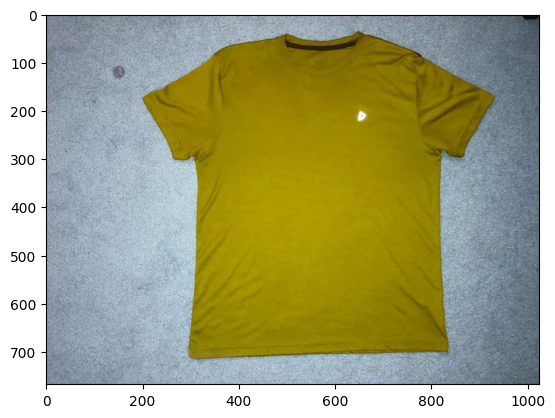

In [9]:
plt.imshow(bestFitImage)
plt.show()

You probably noticed that there is a circular object on the top left of this image. It's a US quarter, and it's there for a reason - to help determine the size of the outfit!

How? Let's understand the problem further.

# How do you measure the size of an object in an image?

Depending on how you take the photograph of the T-Shirt, it might appear smaller in the picture, or larger. So how would you know the true dimensions of the T-Shirt? Seems a bit complex right?

This ia a very common problem in applications that involve object and size detection. The most straight-forward and basic solution is to o define a *ratio* that measures the **number of pixels** per a given **metric**. For this, you'll use a **reference object**, an object that is uniquely identifiable in some manner. This object should have a couple of important properties:
1. Using computer vision, you should be able to easily find this object in the image. Here are some ways to do that:
  - Place this object in the image always in the same place (for example, on the top-left corner). This is perhaps the easiest solution
  - Use an object that's of a distinctive unique color, or a unique shape.
2. You should know the dimensions of this object in some measurable unit (for example, in centimetres, millimetres, or inches).

A US Quarter serves as a good reference object, because you already know it's size, and it's a shape that's unique so therefore easy to identify. You'll place it on the top left before clicking the photograph. Then, here's what you'll do:
1. You'll find contours for the image, and sort them from left-to-right.
2. Once sorted, the contour for the quarter will always be the first contour in the sorted list. You'll grab it and use it to calculate the **number of pixels** per a given **metric**. Here's the formula:


`pixels_per_metric = object_width / known_width`


A US quarter has a known_width of 0.955 inches. So if your `object_width` (measured in pixels) is computed be 150 pixels wide (based on its associated bounding box), the pixels_per_metric will be:


`pixels_per_metric = 150px / 0.955in = 157px`.


This means, that there are approximately 157 pixels per every 0.955 inches in our image. Using this ratio, we can compute the size of objects in an image.


> Source: I found this excellent tutorial from [PyImageSearch](https://www.pyimagesearch.com/2016/03/28/measuring-size-of-objects-in-an-image-with-opencv/)
    
   

**Now that you've got the gist of it, let's begin coding!**

# Image processing

### Convert the best-fit image to grayscale and apply some blur

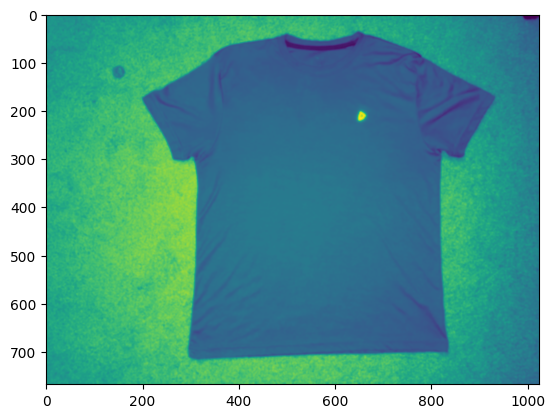

In [11]:
gray = cv2.cvtColor(bestFitImage, cv2.COLOR_BGR2GRAY)
gray = cv2.GaussianBlur(gray, (7, 7), 0)

# Let's see how the gray-scaled image looks like
plt.imshow(gray)
plt.show()

> **Tip**: At any point, if you need to know what a variable contains, or need to see what the results of a certain image processing technique, feel free to use Python's `print` function and Matplotlib's `imshow` and `show` methods

## Next, perform edge detection, then perform a dilation + erosion to close gaps in between object edges

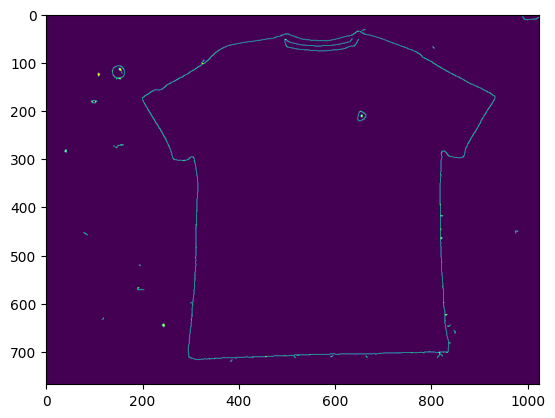

In [12]:
edged = cv2.Canny(gray, 50, 100)
edged = cv2.dilate(edged, None, iterations=1)
edged = cv2.erode(edged, None, iterations=1)

# Display the result
plt.imshow(edged)
plt.show()

### Now that you've detected the edges, you'll now find contours in the edge map.

# What are Contours?
To put it simply, it's a curve joining all the continuous points (along the boundary), having same color or intensity. Contours are a useful tool for shape analysis and object detection and recognition

In [13]:
# find contours in the edge map
cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
cnts = imutils.grab_contours(cnts)

# Print the result
# print(cnts)

Now you have the contours, you'll sort them from left-to-right. Then you'll find the max of these contours, which is the area that your T-shirt occupies

## Sort contours and extract the contour that your T-shirt occupies

In [14]:
# sort the contours from left-to-right and

(cnts, _) = contours.sort_contours(cnts)
cmax = max(cnts, key=cv2.contourArea)
# print(cmax) # Prints [[[646  35]], [[645  36]], [[644  37]] ... [[649  35]], [[648  35]], [[647  35]]]

## Find image moments

An [image moment](https://en.wikipedia.org/wiki/Image_moment) is a certain particular weighted average (moment) of the image pixels' intensities. It allows you to find image properties such as its area (or total intensity), its centroid, and information about its orientation.

In [15]:
# Get the image moment and use it to find the centre
M = cv2.moments(cmax)
# print(M)

# Find the center
cX = int(M["m10"] / M["m00"])
cY = int(M["m01"] / M["m00"])
print(cX, cY)

564 373


### Create an empty canvas for your output image

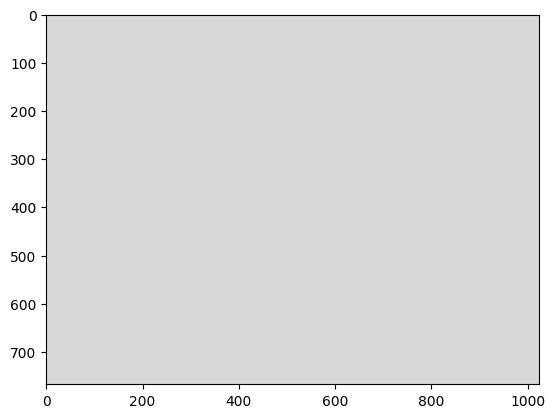

In [16]:
height, width, color = bestFitImage.shape
blank_image = np.zeros((height, width, 3), np.uint8)
blank_image.fill(255) # or img[:] = 255
blank_image =cv2.cvtColor(blank_image, cv2.COLOR_RGB2BGR)
blank_image[:] = (216, 216, 216)
blank_image[:] = (216, 216, 216)

# Display the result
plt.imshow(blank_image)
plt.show()

#### Next, you'll declare the `pixels_per_metric` variable and initialize it to `None` in the beginning.

In [17]:
pixels_per_metric = None
known_width = 0.995 # Width of a US quarter (in inches)

## Examine the contours and calculate the outfit measurements

You'll loop over the contours in-order to examine them. On each loop:
1. First check if the contour area is sufficiently large. If it isn't then you'll ignore it, as it might be just noise from the edge-detection process. 
2. Next, compute the rotated bounding box of the contour.
3. Then organize the points in the contour, such that they appear in top-left, top-right, bottom-right, and bottom-left order, and draw the outline of the bounding box.

Since the reference object is on the top-left, the first iteration will create an outline on the US quarter, and the 2nd iteration would create an outline on the T-Shirt, like this:

  ![On 1st Iteration](./images/image-processing/bounding-box-1st-iteration.png) ![On 2nd Iteration](./images/image-processing/bounding-box-2nd-iteration.png)

4. Next, check if the `pixels_per_metric` variable is initialized. If it isn't, then you'll use the bounding box to calculate the euclidian distance in pixels. This will be the value of `object_width` in the `pixels_per_metric` formula

5. Next, you'll find the top and bottom points of the T-shirt, as well as the Top and Bottom points of the T-shirt sleeve. You'll need these in-order to calculate the width and the height of the T-shirt and also the width of the T-shirt sleeve:

    ![Points on the Tshirt](./images/image-processing/points-on-tshirt.png)

6. Finally, you'll label the measurements on the T-shirt!

![T-shirt measurements](./images/image-processing/tshirt-measurements.png)

In [18]:
# First define a helper function that calculates the mid-point between 2 pairs of coordinates

def midpoint(ptA, ptB):
    return ((ptA[0] + ptB[0]) * 0.5, (ptA[1] + ptB[1]) * 0.5)

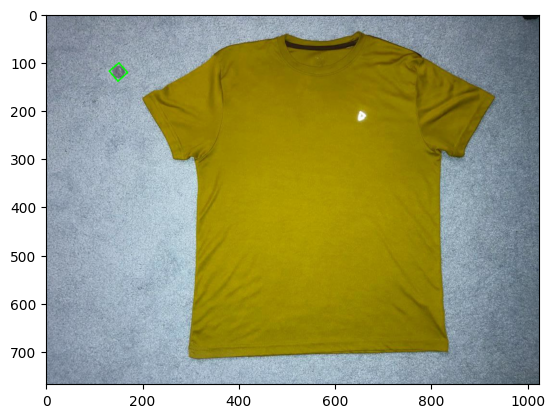

T-shirt width: 18.720345280833584 inches
T-shirt height: 23.81227919722032 inches
T-shirt sleeve: 5.442439360681042 inches


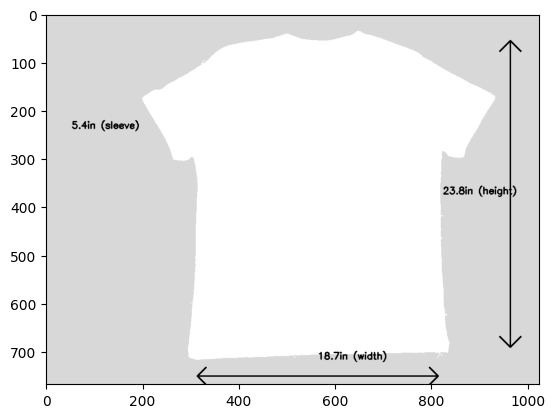

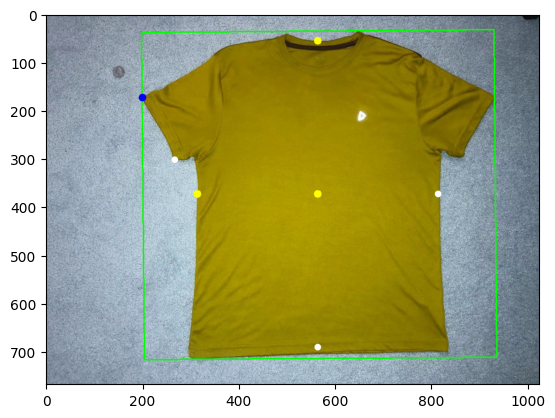

In [19]:
# loop over the contours to examine them
for c in cnts:
    if cv2.contourArea(c) < 100:
        continue
    orig = bestFitImage.copy()
    
    box = cv2.minAreaRect(c)
    box = cv2.cv.BoxPoints(box) if imutils.is_cv2() else cv2.boxPoints(box)
    box = np.array(box, dtype="int")
    
    # order the points in the contour such that they appear in top-left, top-right, bottom-right, and bottom-left order,
    # then draw the outline of the rotated bounding box
    box = perspective.order_points(box)
    cv2.drawContours(orig, [box.astype("int")], -1, (0, 255, 0), 2)
    
    # Calculate the pixels_per_metric variable
    if pixels_per_metric is None:
        (tl, tr, br, bl) = box
        (tlblX, tlblY) = midpoint(tl, bl)
        (trbrX, trbrY) = midpoint(tr, br)
        dB = dist.euclidean((tlblX, tlblY), (trbrX, trbrY))
        pixels_per_metric = dB / known_width

    # If the contour is that of the T-shirt, then calculate the following:
    if cv2.contourArea(c) == cv2.contourArea(cmax):
        cv2.drawContours(blank_image, [cmax], -1, (255, 255, 255), -1)
        # calculate the top for the left sleeve
        leftSleeve_top = tuple(c[c[:, :, 0].argmin()][0])

        # intialize ext bottom ext top and centres
        extBotleft = (0, 0)
        extTop = (0, 0)
        centre = (cX, cY)

        # Calculate the extreme top point of the contour
        for yp in range(cY, 0, -1):
            isOnContour = cv2.pointPolygonTest(c, (cX, yp), False)
            if isOnContour == 0:
                extTop = (cX, yp)
                break
        
        # calculate the bottom left point of the contour
        for xp in range(cX, 0, -1):
            isOnContour = cv2.pointPolygonTest(c, (xp, cY), False)
            if isOnContour == 0:
                extBotleft = (xp, cY)
                break

        widx = dist.euclidean(centre, extBotleft)
        widy = dist.euclidean(centre, extTop)

        extBotRight = (int(cX + widx), cY)
        extDown = (cX, int(cY + widy))

        # calculate the bottom point of the left sleeve
        leftSleeve_bottom = (0, 0)
        yold = leftSleeve_top[1]
        found = False
        for x in cmax:
            for y in x:
                if leftSleeve_bottom != (0, 0):
                    break
                if tuple(y) == leftSleeve_top:
                    found = True
                if found and yold >= y[1]:
                    leftSleeve_bottom = tuple(y)
                else:
                    yold = y[1]

        # Draw points
        cv2.circle(orig, leftSleeve_top, 8, (0, 0, 255), -1)
        cv2.circle(orig, leftSleeve_bottom, 7, (255, 255, 255), -1)
        cv2.circle(orig, extBotleft, 8, (255, 255, 0), -1)
        cv2.circle(orig, extBotRight, 7, (255, 255, 255), -1)
        cv2.circle(orig, extTop, 8, (255, 255, 0), -1)
        cv2.circle(orig, extDown, 7, (255, 255, 255), -1)
        cv2.circle(orig, centre, 8, (255, 255, 0), -1)

        # Calculate the dimensions of the T-shirt! (width, height, and the dimensions of the sleeve)
        outfit_width = widx / pixels_per_metric * 2
        outfit_height = widy / pixels_per_metric * 2
        
        sleevedist = dist.euclidean(leftSleeve_top, leftSleeve_bottom)
        outfit_sleeve = sleevedist / pixels_per_metric
        
        # print the measurements
        print(F"T-shirt width: {outfit_width} inches")
        print(F"T-shirt height: {outfit_height} inches")
        print(F"T-shirt sleeve: {outfit_sleeve} inches")
        
        # Draw and label the measurements on the T-shirt image
        displaypoint = midpoint(leftSleeve_top, leftSleeve_bottom)
        
        cv2.arrowedLine(blank_image, (int(centre[0] - widx), int(centre[1]+widy+60)), (int(centre[0] + widx), int(centre[1]+widy+60)),
                     (0, 0, 0), 2, tipLength=0.05)
        cv2.arrowedLine(blank_image,
                        (int(centre[0] + widx), int(centre[1] + widy + 60)),
                        (int(centre[0] - widx), int(centre[1] + widy + 60)),
                        (0, 0, 0), 2, tipLength=0.05)
        cv2.arrowedLine(blank_image, (int(centre[0] + widx+150), int(centre[1] - widy)), (int(centre[0]+widx+150), int(centre[1] + widy)),
                 (0, 0, 0), 2, tipLength=0.05)
        cv2.arrowedLine(blank_image,  (int(centre[0] + widx + 150), int(centre[1] + widy)),
                        (int(centre[0] + widx + 150), int(centre[1] - widy)),
                        (0, 0, 0), 2, tipLength=0.05)

        cv2.putText(blank_image, "{:.1f}in (sleeve)".format(outfit_sleeve),
                    (int(displaypoint[0]-180), int(displaypoint[1])), cv2.FONT_HERSHEY_SIMPLEX,
                    0.65, (0, 0, 0), 2)
        cv2.putText(blank_image, "{:.1f}in (width)".format(outfit_width),
                    (int(extDown[0]), int(extDown[1] + 25)), cv2.FONT_HERSHEY_SIMPLEX,
                    0.65, (0, 0, 0), 2)

        cv2.putText(blank_image, "{:.1f}in (height)".format(outfit_height),
                    (int(extBotRight[0] + 10), int(extBotRight[1])), cv2.FONT_HERSHEY_SIMPLEX,
                    0.65, (0, 0, 0), 2)
        
        plt.imshow(blank_image)
        plt.show()
        
    # Display the result
    plt.imshow(orig)
    plt.show()

### Exercise

### You used the above techniques to find the size of your best-fit T-shirt. Now, you'll repeat the same steps to find the size of the T-shirt that you'd like to buy.

Once you have the measurements for both, you can compare their differences and calculate the percentage of best fit!

# What is right is often forgotten by what is convenient. And it is evident in the world of fashion e-commerce!

> The right choice is hardly ever the easy choice. But it can be a smart one!